In [ ]:
!pip install -e ..

In [1]:
import os
import tarfile
import shutil
import dask
import requests
import time
import psutil

import numpy as np
import xarray as xr
import scipy.constants
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from astrohack import holog
from astrohack.panel import panel
from astrohack.dio import extract_holog
from astrohack.dio import _load_holog_file
from astrohack._utils._io import _make_ant_pnt_dict
from astrohack._utils._io import _read_meta_data

from dask.distributed import Client, LocalCluster

plt.rcParams["figure.figsize"] = (15, 15)

In [2]:
def performance(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        stop = time.time()
        print("Completion time: {}".format(stop - start))
    return wrapper

def _open_holog(hack_file, ddi):   
    ant_grid_data = {}
    
    ant_list =  [dir_name for dir_name in os.listdir(hack_file) if os.path.isdir(hack_file)]
    for ant in ant_list:
        ant_grid_data[int(ant)] = xr.open_zarr("{name}/{ant}/{ddi}".format(name=hack_file, ant=ant, ddi=ddi) )
        
    return ant_grid_data

def print_hack_file(hack):
    for ddi in hack.keys():
        for scan in hack[ddi].keys():
            for ant in hack[ddi][scan].keys():
                print("="*150)
                print("\t\t\t\t\t\t\tddi={ddi}\tscan={scan}\t ant={ant}".format(ddi=ddi, scan =scan, ant=ant))
                print("="*150)
                print("{xds}".format(xds=hack[ddi][scan][ant]))

def print_hack_directory_struct(name):
    for ddi in os.listdir(name):
        if ddi.isnumeric():
            print(ddi,"/")
            for scan in os.listdir("{name}/{ddi}".format(name=name, ddi=ddi)):
                if os.path.isdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)) == False:
                    print("|---", scan)
                    pass
                else:
                    print("|---", scan, "/")
                    for ant in os.listdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)):
                        print("\t|---", ant, "/")
                
def get_max_memory_allocation():
    memory_string = str(int((psutil.virtual_memory().total/1e9)/os.cpu_count()))
    return "".join((memory_string, 'GB'))

def get_example_data():
    #google_file_id = '1zpOtduyXtbh0wg0s5KWYuEMy7roGq92a'
    google_file_id = '10lX6kki638xeDhDKw51tk0h9pbleMx0z'
    #output = 'alma_band3.calibrated.DV16.ms.tar'
    output = 'alma_band3.calibrated.DA44.ms.tar'
    path = "/".join((os.getcwd(), output))
    
    download_file_from_google_drive(
        id=google_file_id,
        destination=path
    )

    
    tar = tarfile.open(path)
    tar.extractall()
    tar.close()
    
    os.remove(path)
    
    return path.split('.tar')[0]

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id , 'confirm': 1 }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Setup
This data file is a subset of a larger band3, calibrated holography measurement. The file contains a single ddi, a single scan and only baselines containing antenna DV16.

In [3]:
if os.path.exists('alma_band3.calibrated.DA44.ms') == False:
    ms_name = get_example_data()
else:
    ms_name = 'alma_band3.calibrated.DA44.ms'
    
# Change this to the path to the larger file
#ms_name = '<PATH_TO_LARGER_FILE>/J1924-2914.ms.split.calibrated.SPW3'

Here we setup the Dask distributed client which will be used to add parallelism to our jobs. In this case, we will use a total of 6 workers with a single thread and 8Gb of memeory each. The dashboard link that is returned allows the user to monitor each jobs from the browser.

![title](documentation/dask_dashboard.png)

In [4]:
# try:
#     client = Client('http://127.0.0.1:8787')

# except:
#     cluster = LocalCluster(
#         n_workers=6,
#         threads_per_worker=1,
#         memory_limit='8GB'
#     )

#     client = Client(cluster)
        
# print(client.dashboard_link)

This input format to the `extract_holog(...)` function is in the form of a nested dictionary. The structure is as follows:
```yaml
ddi: {
    scan:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
},
.
.
.
ddi_n: {
    scan_n:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
}
```
The above is the structure for the case of a single (ddi, scan_ but the format can support *n* cases of (ddi, scan). This is user provided information based on the specific holography run being processed.

In [5]:
DA = [
    'DA41', 'DA42', 'DA43', 
    'DA44', 'DA45', 'DA46', 
    'DA48', 'DA49', 'DA50', 
    'DA51', 'DA52', 'DA53', 
    'DA54', 'DA55', 'DA56', 
    'DA57', 'DA58', 'DA59'
]
DV = [
    'DV02', 'DV03', 'DV04', 
    'DV11', 'DV12', 'DV13', 
    'DV14', 'DV15', 'DV16', 
    'DV17', 'DV18', 'DV19', 
    'DV20', 'DV21', 'DV22', 
    'DV23', 'DV24', 'DV25'
] 

holog_obs_description = {
    0:{
        4:{
            'map':DA,
            'ref':DV
        }
    }
}

#holog_obs_description = {0:{2:{'map':DV,'ref':DA}, 6:{'map':DV,'ref':DA}, 10:{'map':DV,'ref':DA},4:{'map':DA,'ref':DV}, 8:{'map':DA,'ref':DV}, 12:{'map':DA,'ref':DV}}}

# Extract Holography Data

The extraction of the holography data is done effectively by leveraging the Dask based parallelism and compiled code via numba jit functions. There are also optimizations done by extracting only the minimum subsets of data that are needed to build the output data structure which will be used for the holography analysis. In addition, we found significant table query gains by using `pycasacore`; as much as x10 speed up. A psuedocode skeleton of how the extraction is done is shown below.

- `extract_holog(...)`
    - `make_pnt_dict`(parallel axis: `antenna`) extract a subset of the pointing table data needed for the holography analysis. 
    - gather relevant spectral window information as well as odservation type information,  e.g.(MAP_ANTENNA_SURFACE#MIXED). Only keep data of a relevant type.
    - `_extract_holog_chunk(...)`(parallel axes: ddi, scan) 
        - pull data from main table
        - get unique scan time values
        - `_extract_holog_chunk_jit` (this is jit compiled code): 
            - for each row:
                - skip flagged rows
                - get only relevant baselines, i.e. no auto correlation
                - get baseline visibility data
                - for each chan, pol:
                    - calculate weighted sum visibilities 
                    - calculate running sum of weights
            - for unique_time, chan, pol:
                - calculate weighted visibilities
    - `_extract_pointing_chunk(...)`
        - extract directional cosines data by sampling the time values nearest the main table unique values.
    - `_create_hack_file(...)`
        - create hackfile data structure that contains both the visibility and the directional cosines data using common time indexing.
                


In [6]:
%%time
extract_holog(
    ms_name=ms_name, 
    holog_name='hack_file', 
    holog_obs_dict=None,
    data_col='DATA',
    subscan_intent='MIXED',
    parallel=True,
    overwrite=True
)

[2023-02-15 14:13:42.007989 Warning]: [extract_holog] Warning, current holography files will be overwritten.
Successful readonly open of usernoread-locked table alma_band3.calibrated.DA44.ms/ANTENNA: 8 columns, 36 rows
Successful readonly open of usernoread-locked table alma_band3.calibrated.DA44.ms: 22 columns, 169785 rows
[2023-02-15 14:13:48.213824 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack_file.point.zarr/27[2023-02-15 14:13:48.214209 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack_file.point.zarr/18

[2023-02-15 14:13:48.214870 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack_file.point.zarr/35
[2023-02-15 14:13:48.215064 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack_file.point.zarr/4
[2023-02-15 14:13:48.215371 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack_file.point.zarr/0
[2023-02-15 14:13:48.215563 System Info]: [_make_ant_pnt_xds_chunk] Writing pointing xds to hack

The output of `extract_holog(...)` is `hackfile` containing the extract holography information for each (ddi, scan, ant) as well as relevant meta data used later for gridding. The format of the `hackfile` on disk is a directory structure ordered as `hackfile/ddi/scan/antenna/` with an `xarray.Dataset()` at the end.

The directory structure and `xarray.Dataset()` format are shown below for the example data.

In [7]:
print_hack_directory_struct(name='hack_file.holog.zarr')

0 /
|--- .DS_Store
|--- .holog_attr
|--- .hack_attr
|--- 4 /
	|--- 9 /
	|--- 11 /
	|--- 7 /
	|--- 16 /
	|--- 6 /
	|--- 17 /
	|--- 10 /
	|--- 8 /
	|--- 4 /
	|--- 15 /
	|--- 3 /
	|--- 12 /
	|--- 13 /
	|--- 5 /
	|--- 14 /
|--- 2 /
	|--- 32 /
	|--- 35 /
	|--- 34 /
	|--- 33 /
	|--- .DS_Store /
	|--- 27 /
	|--- 29 /
	|--- 28 /
	|--- 26 /
	|--- 31 /
	|--- 30 /


In [8]:
antenna = 3

hack, ant_data_dict = _load_holog_file(
    "{root}/{hack}".format(root=os.getcwd(), hack='hack_file.holog.zarr'), 
    dask_load=True, 
    load_pnt_dict=False, 
    ant_id=antenna
)

print_hack_file(hack=hack)

							ddi=0	scan=4	 ant=9
<xarray.Dataset>
Dimensions:              (time: 2401, lm: 2, chan: 64, pol: 4)
Coordinates:
  * chan                 (chan) float64 1.09e+11 1.09e+11 ... 1.109e+11 1.11e+11
  * pol                  (pol) int32 9 10 11 12
  * time                 (time) float64 5.045e+09 5.045e+09 ... 5.045e+09
Dimensions without coordinates: lm
Data variables:
    DIRECTIONAL_COSINES  (time, lm) float64 dask.array<chunksize=(2401, 2), meta=np.ndarray>
    VIS                  (time, chan, pol) complex64 dask.array<chunksize=(1201, 32, 2), meta=np.ndarray>
    WEIGHT               (time, chan, pol) float64 dask.array<chunksize=(1201, 32, 2), meta=np.ndarray>
Attributes:
    ant_id:               9
    ddi:                  0
    parallactic_samples:  [4.304342259912087, 4.305802195849923, 4.3070602903...
    scan:                 4
    telescope_name:       ALMA
							ddi=0	scan=4	 ant=11
<xarray.Dataset>
Dimensions:              (time: 2401, lm: 2, chan: 64, pol: 4)
Coordin

In addition to producing the `hackfile` and antenna based dictionary is also produced which is indexed according to antenna/ddi/scan. This allows us to more easily access the data for antenna based gridding in Dask. An example for antenna-27 is shown below.

In [9]:
time = hack[0][4][antenna].time.values
l = hack[0][4][antenna].DIRECTIONAL_COSINES[:, 0]
m = hack[0][4][antenna].DIRECTIONAL_COSINES[:, 1]

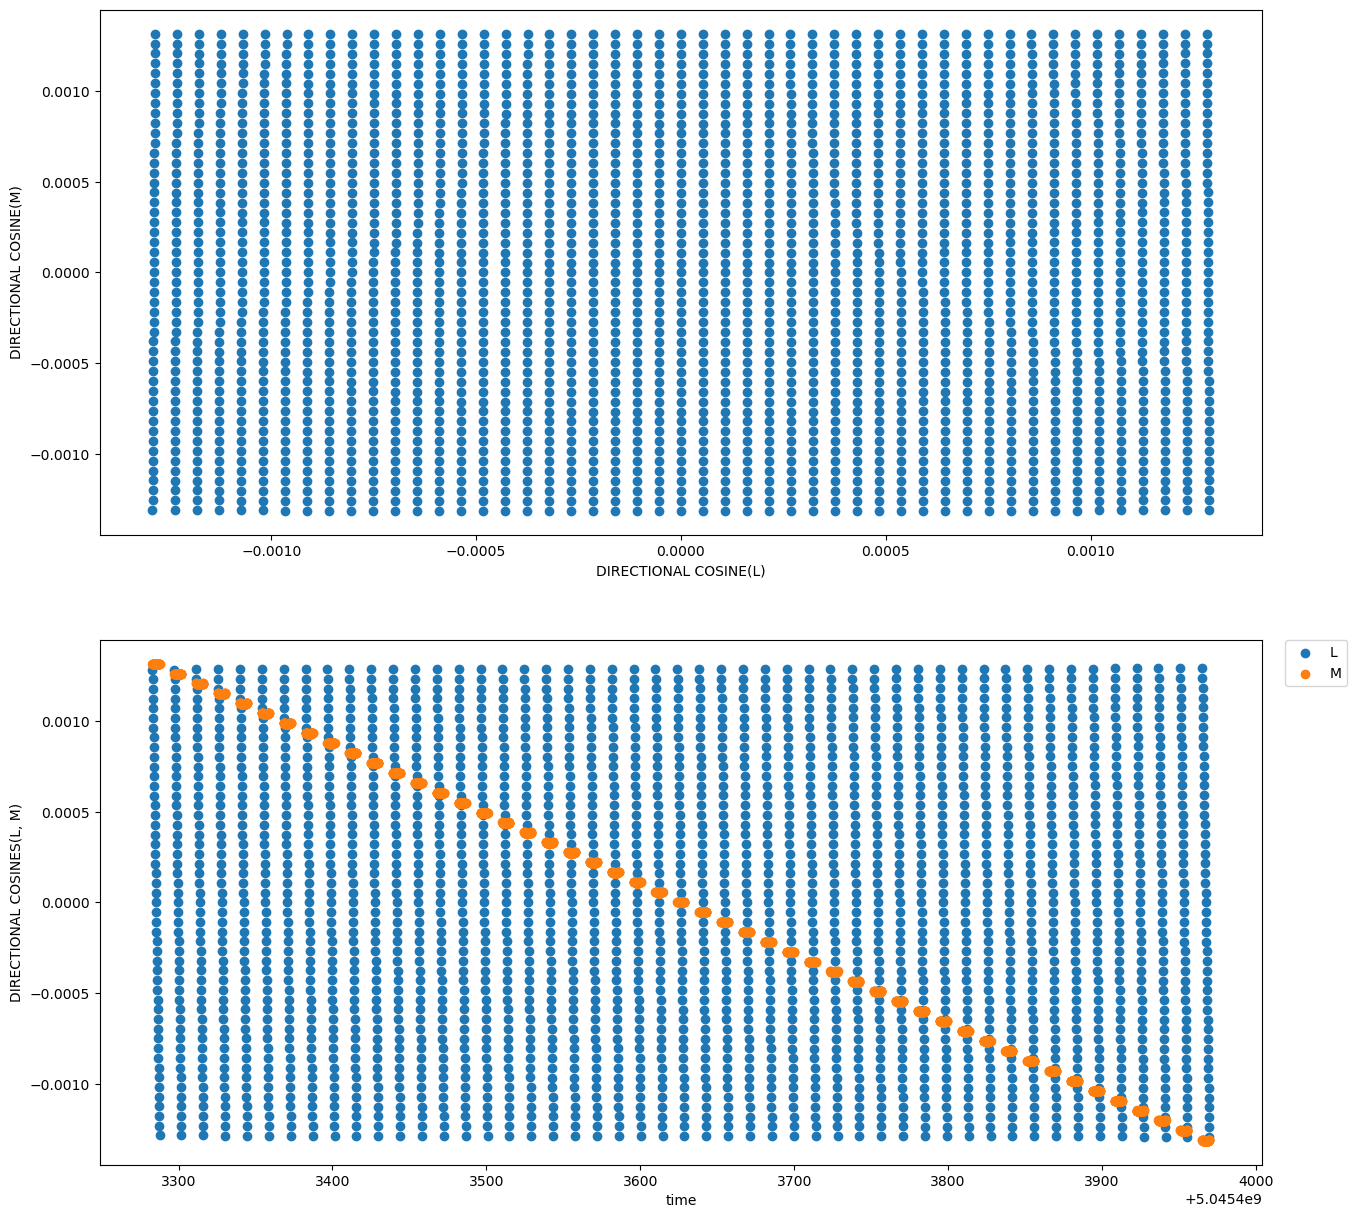

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].scatter(l, m)
ax[0].set_xlabel('DIRECTIONAL COSINE(L)')
ax[0].set_ylabel('DIRECTIONAL COSINE(M)')

ax[1].scatter(time, l, label='L')
ax[1].scatter(time, m, label='M')

ax[1].set_xlabel('time')
ax[1].set_ylabel('DIRECTIONAL COSINES(L, M)')

ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0.)

plt.show()

In [11]:
%%time
holog(
    holog_file='hack_file.holog.zarr', 
    padding_factor=50, 
    parallel=True
)

[2023-02-15 14:14:11.568608 System Info]: Loading holography file hack_file.holog.zarr ...


/Users/jsteeb/mambaforge-pypy3/envs/zinc/lib/python3.8/site-packages/xarray/core/common.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self.values, dtype=dtype)


[2023-02-15 14:14:16.160382 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.240948 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.319442 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.543507 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.549902 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.563636 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.567575 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:16.575709 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:14:22.212472 System Info]: [_holog_chunk]

/Users/jsteeb/mambaforge-pypy3/envs/zinc/lib/python3.8/site-packages/xarray/core/common.py:165: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self.values, dtype=dtype)


[2023-02-15 14:15:53.816442 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:15:54.647547 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:15:55.262122 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:15:55.822467 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:15:56.179332 System Info]: [_holog_chunk] Applying phase correction ...
[2023-02-15 14:15:57.251215 System Info]: [_holog_chunk] Applying phase correction ...
[2023-02-15 14:15:57.880880 System Info]: [_calculate_aperture_pattern] Calculating aperture illumination pattern ...
[2023-02-15 14:15:58.279360 System Info]: [_holog_chunk] Applying phase correction ...
[2023-02-15 14:15:58.552717 System Info]: [_holog_chunk] Applying phase correction ...
[2023-02-15 14:15:58.564810 System Info]: [_calculate_aperture

In [12]:
ant_grid_data = _open_holog('hack_file.image.zarr', ddi=0)

antenna = 3

FileNotFoundError: No such file or directory: '/Users/jsteeb/Dropbox/astrohack/examples/hack_file.image.zarr/.DS_Store/0'

In [ ]:
ant_grid_data[antenna]

In [ ]:
hack, ant_data_dict = _load_holog_file("{root}/{hack}".format(root=os.getcwd(), hack='hack_file.holog.zarr'), dask_load=True, load_pnt_dict=False, ant_id=antenna)

In [ ]:
grid = ant_grid_data[antenna].BEAM.values.mean(axis=0)[0, 0, ...]
l = ant_grid_data[antenna].l.values
m = ant_grid_data[antenna].m.values

fig, ax = plt.subplots()

beam = plt.imshow(np.abs(grid), extent=[l.min(), l.max(), m.min(), m.max()], cmap='plasma')
fig.colorbar(beam, ax=ax)

In [ ]:
wavelength = scipy.constants.speed_of_light/ant_grid_data[3].chan.values[0]

In [ ]:
aperture = ant_grid_data[antenna].APERTURE.values.mean(axis=0)[0, 0, ...]
u = ant_grid_data[antenna].u.values*wavelength
v = ant_grid_data[antenna].v.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(np.abs(aperture), extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

circle = patches.Circle((0,0), 6, fill=False, color='white', alpha=0.7, linewidth=1.2)
ax.add_patch(circle)

In [ ]:
aperture = ant_grid_data[antenna].AMPLITUDE.values.mean(axis=0)[0, 0, ...]
u = ant_grid_data[antenna].u_prime.values*wavelength
v = ant_grid_data[antenna].v_prime.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(aperture, extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

In [ ]:
aperture = ant_grid_data[antenna].ANGLE.values.mean(axis=0)[0, 0, ...]
u = ant_grid_data[antenna].u_prime.values*wavelength
v = ant_grid_data[antenna].v_prime.values*wavelength

fig, ax = plt.subplots()

image = plt.imshow(aperture, extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

In [ ]:
%%time
image = 'hack_file'

panel(
    holog_image=image, 
    outfile='hack_panel',
    aipsdata=False, 
    unit='miliinches', 
)